# Detección de Neumonía a partir de imágenes de rayos X
### **P3:** Aprendizaje Profundo - CICESE

> **Estudiante:** [Joel Ricci López](https://github.com/jRicciL), 2021

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jRicciL/Aprendizaje_profundo_tareas_CICESE/blob/master/Tarea_3_CNN/P3_ConvolutionalNN_PNEUMONIA_X_ray.ipynb)

***
<br>

## Planteamiento
*Implementar una red neuronal basada en la estrategia de transferencia deconocimiento para resolver el el problema de clasificación de neumonías  presentado  en  Kaggle.  Use la red preentrenada de su elección.*

<br>

## Estrategia de Solución

La estrategia seguida fue la siguiente:
1. **Descargar los datos de Kaggle**: [Chest X-ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).
2. Los **datos fueron descargados en Colab** y los conjuntos fueron modificados para que se cumpliera lo siguiente:  
  - Conjunto de **Entrenamiento**: 80% de las imágenes.
  - Conjuntos de **Validación** y **Prueba**: 10% de las imágenes cada uno.
  - Se aseguró que la proporción de imágenes de las clases <font color='red'><code>PNEUMONIA</code></font> y <font color='#44B275'><code>NORMAL</code></font> fuera la misma en cada conjunto.
3. Esta fase preliminar se realizó en el siguiente notebook: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jRicciL/Aprendizaje_profundo_tareas_CICESE/blob/master/Tarea_3_CNN/P3_Preprocess_CNN_Pneumonia.ipynb)
4. Se realizó una fase de Análisis Exploratorio con las imágenes.
5. Se implementó una red **neuronal convolucional (CNN**) con Keras para la clasificación de las imágenes.  
  **a)** Se evaluó el desempeño de la CNN con el conjunto de prueba.
6. Se implementó **una red neuronal convolucional basada en transferencia de conocimiento.**  
  **a)** Se tomó como base la red preentrenada **VGG16** con los pesos de `imagenet`.  
  **b)** Se evaluó el desempeño de la red VGG16-base con el conjunto de prueba.


## Preliminares y carga de datos
### Montamos el acceso a Drive para cargar los datos

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')
root_path = '/content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray'
%cd $root_path/
%ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray
chest_xray/        modelo_neu_jrl_TRAINED.h5              test/
history_cnn.pkl    modelo_vgg16_jrl.h5                    train/
__MACOSX/          modelo_VGG16_jrl_trained_20_epocas.h5  val/
modelo_neu_jrl.h5  output.png


### Carga de las ibrerías a utilizar

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk', palette='Spectral', font_scale=0.9)

In [3]:
# Variables con los paths a los directorios de cada conjunto
test_dir = os.path.join(root_path, 'test')
train_dir = os.path.join(root_path, 'train')
val_dir = os.path.join(root_path, 'val')

# Análisis Exploratorio

Num. de casos positivos: 4273 = 0.73
Num. de casos negativos: 1583 = 0.27


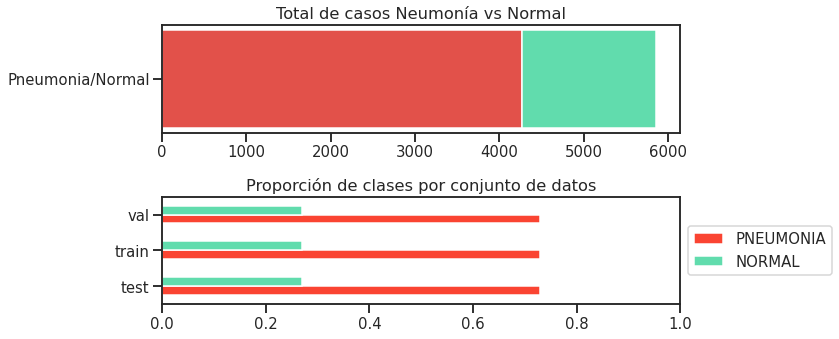

In [4]:
#@title Proporción de clases en los conjuntos de datos {display-mode: "form"}
#@markdown Las siguiente gráfica muestra la proporción 
#@markdown de clases en cada conjunto de datos.

# Contamos el número de imágenes pertenecientes a cada conjunto
def count_samples():
  samples = {}
  for set_ in ['test', 'train', 'val']:
    samples[set_] = {}
    for class_ in ['NORMAL', 'PNEUMONIA']:
      path = os.path.join(root_path, set_)
      k = len(os.listdir(f'{path}/{class_}'))
      samples[set_].update({class_: k})
  # Almacenamos los datos en un pequeño dataframe
  df_samples = pd.DataFrame(samples)
  return df_samples

df_samples = count_samples()

# Número total de observaciones
n = df_samples.values.sum()
# Número de casos positivos y de casos negativos
n_neg, n_pos = df_samples.sum(axis = 1).values

print(f'Num. de casos positivos: {n_pos} = {n_pos / n:.2f}')
print(f'Num. de casos negativos: {n_neg} = {n_neg / n:.2f}')

# Visualización
fig, ax = plt.subplots(2,1, figsize=(10, 5))
# Número total de casos
ax[0].barh(['Pneumonia/Normal'], [n_pos])
ax[0].barh(['Pneumonia/Normal'], [n_neg], left=[n_pos], 
           color='#61dcad')
ax[0].set(title='Total de casos Neumonía vs Normal')
# Proporción de etiquetas por set
(df_samples / df_samples.sum()).iloc[::-1].T.plot(kind='barh', 
      ax = ax[1], xlim=(0, 1), 
      color = ['#fa4432', '#61dcad'],
      title='Proporción de clases por conjunto de datos')
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### Definición de las clases:

1. <font color='#fa4432'>&#11044;</font> Positivo = `PNEUMONIA`
2. <font color='#61dcad'>&#11044;</font> Negativo = `NORMAL`

#### Tamaño de los conjuntos
1. Entrenamiento: 80%
1. Validación: 10%
1. Prueba: 10%

In [5]:
# Número total de observaciones
n = df_samples.values.sum()
# Número de casos positivos y de casos negativos
n_neg, n_pos = df_samples.sum(axis = 1).values

### Mostramos algunas imágenes de ejemplo

Se muestra una imagen aleatoria de ejemplo por cada conjunto de entrenamiento  (`train`, `test`, `val`) y por cada clase (<font color='red'><code>PNEUMONIA</code></font> y <font color='#44B275'><code>NORMAL</code></font>).
- Se obseva que las dimensiones de las imágenes no son uniformes, lo cual deberá tomarse en cuenta cuando se implemente el generador de imágenes con **Keras**.

In [6]:
import tensorflow.keras as k
from tensorflow.keras.preprocessing.image import load_img, img_to_array 

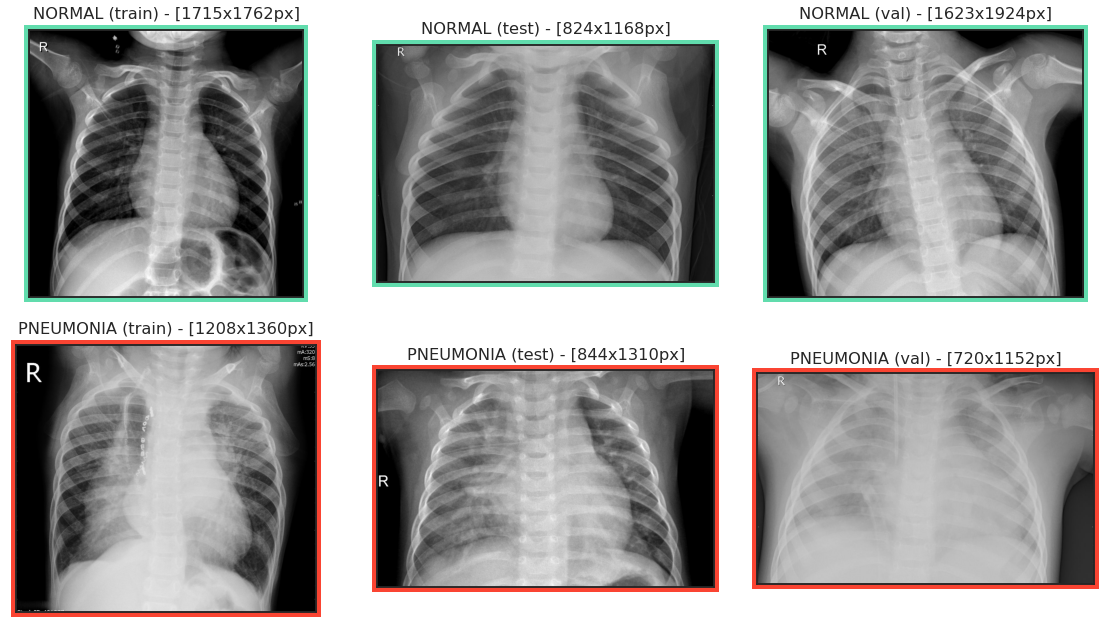

In [7]:
#@title Imágenes de ejemplo
#@markdown (desplegar la celda para ocultar/mostrar al código)
def show_random_images():
  fig, ax = plt.subplots(2, 3, figsize=(16, 9))
  for i, class_ in enumerate(['NORMAL', 'PNEUMONIA']):
    for j, set_ in enumerate(['train', 'test', 'val']):
      path = f'{root_path}/{set_}/{class_}/'
      files = os.listdir(path)
      file = np.random.choice(files, size=1, replace=False)[0]
      file_path = f'{path}/{file}'
      color = '#fa4432' if class_ == 'PNEUMONIA' else '#61dcad'
      img = load_img(file_path)
      n, m, c = img_to_array(img).shape
      ax[i, j].imshow(img)
      ax[i, j].set_title(
          f'{class_} ({set_}) - [{n}x{m}px]', y = 1.02)
      ax[i, j].grid(False)
      ax[i, j].set_xticks([])
      ax[i, j].set_yticks([])
      ax[i, j].patch.set_edgecolor(color)  
      ax[i, j].patch.set_linewidth('10')
  plt.tight_layout()
  plt.show()

show_random_images()

### Propiedades de las imágenes


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

A continuación se carga una **muestra de 150 imágenes por conjunto** (`train`, `test`, `val`) y por clase (<font color='red'><code>PNEUMONIA</code></font> y <font color='#44B275'><code>NORMAL</code></font>). A partir de esta muestra se hará un análisis exploratorio para comparar el conjunto de imágenes tanto entre clases como entre conjuntos.
- La función `images_to_array()` permite cargar la muestra de imágenes en formato `np.ndarray`.

In [9]:
def images_to_array(directory, target_size = (150, 150), n_samples = 150):
  ''' Lee n número de imágenes aleatorias del directorio indicado
      y devuelve un arreglo numpy de las mismas'''
  files = os.listdir(directory)
  # Muestrea aleatoriamente n imágenes
  files = np.random.choice(files, size=n_samples, replace = False)
  for file in files:
    img = load_img(f'{directory}/{file}', 
                  target_size = target_size, 
                  color_mode = 'grayscale')
    img_arr = img_to_array(img)
    try:
      imgs_tensor = np.concatenate([imgs_tensor, img_arr], axis=2)
    except UnboundLocalError:
      imgs_tensor = img_arr

  return imgs_tensor

In [10]:
%%time
IMG_WIDTH, IMG_HEIGHT = 150, 150
sets = ['train', 'test', 'val']
classes = ['NORMAL', 'PNEUMONIA']

# Recopila 150 imágenes de cada directorio
sample_images = {}
for set_ in sets:
  sample_images[set_] = {}
  for class_ in classes:
    directory = f'{root_path}/{set_}/{class_}'
    imgs = images_to_array(directory  = directory, 
                          target_size =(IMG_WIDTH, IMG_HEIGHT))
    sample_images[set_][class_] = imgs
    
sample_images.keys()

CPU times: user 9.16 s, sys: 302 ms, total: 9.46 s
Wall time: 10.3 s


#### Imágenes promedio por conjunto y clase

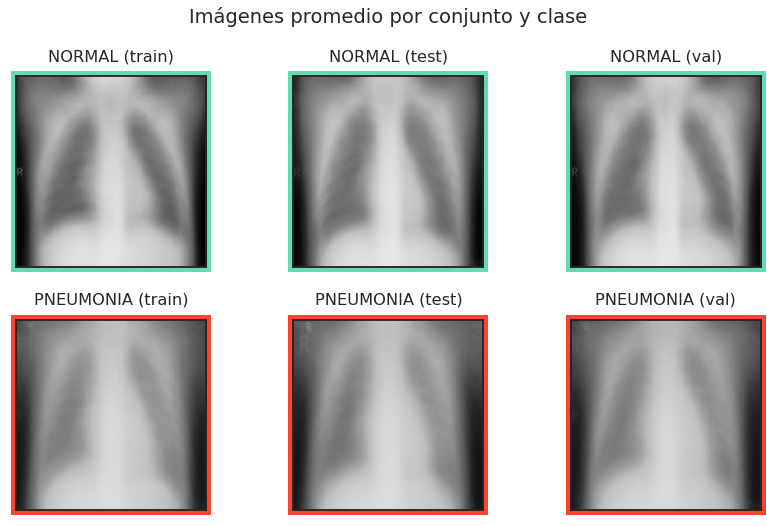

In [11]:
#@markdown La siguiente figura muestra una imagen promedio por cada conjunto y clase 
#@markdown del conjunto de datos.

#@markdown El código para generar la figura se puede desplegar en esta misma celda.

fig, ax = plt.subplots(2, 3, figsize=(12, 7))

for i, set_ in enumerate(sets):
  for j, class_ in enumerate(classes):
    imgs_tensor = sample_images[set_][class_]
    mean_image = np.mean(imgs_tensor, axis=2)
    color = '#fa4432' if class_ == 'PNEUMONIA' \
            else '#61dcad'

    ax[j, i].imshow(mean_image, 
                    vmin=0, vmax=255, 
                    cmap='Greys_r')
    ax[j, i].set_title(f'{class_} ({set_})', y = 1.05)
    ax[j, i].set_xticks([])
    ax[j, i].set_yticks([])
    ax[j, i].patch.set_edgecolor(color)  
    ax[j, i].patch.set_linewidth('10')  
plt.tight_layout()
plt.suptitle("Imágenes promedio por conjunto y clase", y = 1.05)
plt.show()

Es posible observar que, independientemente del conjunto, la clase <font color='red'><code>PNEUMONIA</code></font> tiende a mostrar una mayor densidad en el campo intrapulmonar, es decir, **la zona interna de los pulmones se ve más iluminada** (intensa) en las **muestras con neumonía**.

#### Histogramas de intensidad y función de distribución acumulada (FDA)

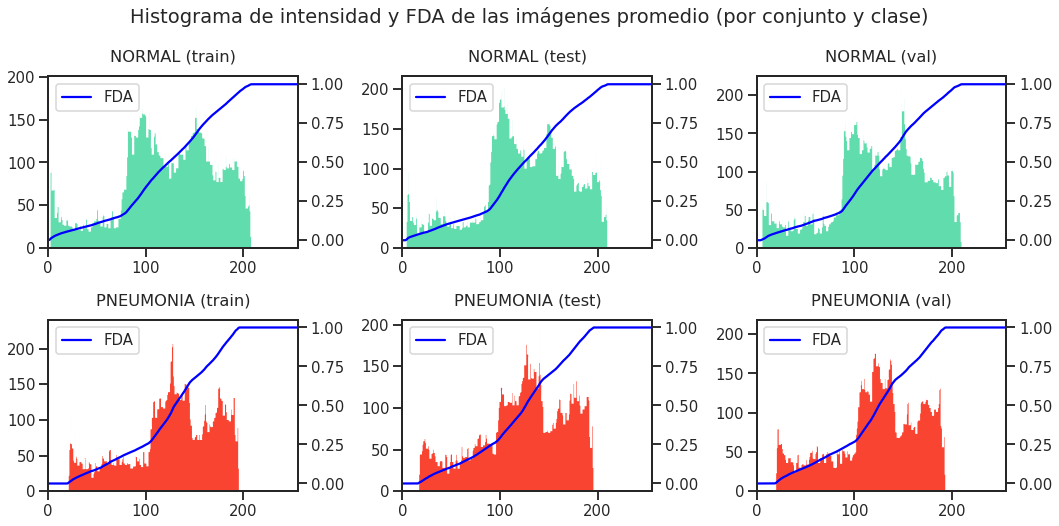

In [12]:
#@markdown La siguiente figura muestra los histogramas de intensidad de cada
#@markdown  **imagen promedio** así como la función de distribución acumulada de
#@markdown dichos valores.

import scipy.ndimage as ndi 

fig, ax = plt.subplots(2, 3, figsize=(15, 7))

for i, set_ in enumerate(sets):
  for j, class_ in enumerate(classes):
    color = '#fa4432' if class_ == 'PNEUMONIA' else '#61dcad'
    imgs_tensor = sample_images[set_][class_]
    mean_image = np.mean(imgs_tensor, axis=2)
    mean_image_arr = mean_image.ravel()
    # Grafica el histograma
    ax[j, i].hist(mean_image_arr, bins = 256, 
                  histtype = 'stepfilled', color = color)
    hist = ndi.histogram(mean_image, min = 0, max = 255, bins = 256)
    # Grafica la función de distribución acumulada
    cdf = hist.cumsum()  / hist.sum()
    ax_2 = ax[j, i].twinx()
    ax_2.plot(cdf, c='blue')
    ax_2.legend(['FDA'])
    ax[j, i].set_title(f'{class_} ({set_})', y = 1.05)
    ax[j, i].set(xlim = (0, 256))
plt.suptitle("Histograma de intensidad y FDA de las imágenes promedio (por conjunto y clase)", y = 1.05)
plt.tight_layout()
plt.show()

En los histogramas de intensidad se observa la **frecuencia de intensidad de los pixeles** de las imágenes promedio mostradas en la figura anterior. A partir de estas imágenes promedio podemos suponer lo siguiente para cada conjunto de imágenes:
- Es posible notar que las imáges con la etiqueta <font color='#44B275'><code>NORMAL</code></font> muestran **picos de intensidad en 100 y 150**.
- Por otro lado, las imágenes con etiqueta <font color='red'><code>PNEUMONIA</code></font> **NO muestran este mismo patrón**.
- En general, las imágenes con <font color='red'><code>PNEUMONIA</code></font> **no alcanzan intensidades mayores a 200.**

#### Imágenes promedio y desviación estándar por clase

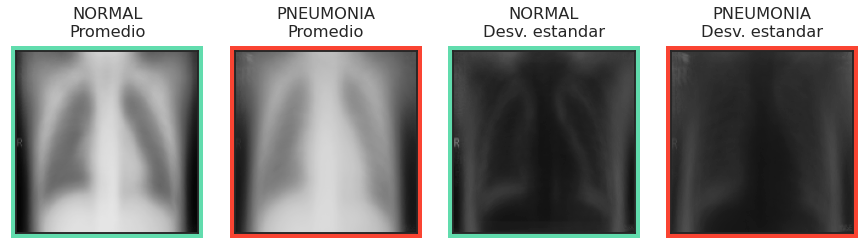

In [13]:
#@markdown La siguiente figura muestra la **imagen promedio de cada clase** así como
#@markdown la **desviación estándar** de cada imagen.

fig, ax = plt.subplots(1, 4, figsize = (15, 4))

for j, class_ in enumerate(classes):
  color = '#fa4432' if class_ == 'PNEUMONIA' else '#61dcad'
  all_imgs = np.concatenate([sample_images[set_][class_] 
                             for set_ in sets], axis = 2)
  mean_img = np.mean(all_imgs, axis = 2)
  std_img = np.std(all_imgs, axis = 2)
  img_dic = {'Promedio': mean_img, 'Desv. estandar': std_img}
  for i, key in zip(range(0, 4, 2), img_dic.keys()):
    ax[j+i].imshow(img_dic[key], vmin=0, vmax=255, cmap='Greys_r')
    ax[j+i].patch.set_edgecolor(color)  
    ax[j+i].patch.set_linewidth('10')
    ax[j+i].set_title(f'{class_}\n{key}', y = 1.05)
    ax[j+i].set_xticks([])
    ax[j+i].set_yticks([])
plt.show()

En la figura anterior es posible **comparar la imagen promedio de las imágenes** de la clase <font color='green'><code>NORMAL</code></font>  vs la clase <font color='red'><code>PNEUMONIA</code></font>, así como **la variabilidad de las intensidades** de cada clase en términos de desviación estádar. Se observa lo siguiente:
- Como en las figuras anteriores, las imágenes de la clase <font color='red'><code>PNEUMONIA</code></font> muestran una mayor densidad en la región torácica. 
- Las imágenes  <font color='green'><code>NORMAL</code></font> tienen mayor contraste y bordes más definidos entre los elementós óseos (blanco) y región del parénquima pulmonar (negro).


***

# Red Convolucional

**A continuación se muestra la implementación de una red neuronal convolucional para clasificación de radiografías de torax.**
1. Se usarán las imágenes de los conjuntos `train` y `val` para la fase de entrenamiento.
2. Se usará la clase `ImageDataGenerator` de Keras como método de aumento de datos.
3. Se tomará en cuenta el desbalance de clases para la inicialización de los pesos de la capa de salida de la red.
4. Se utilizará el optimizador Adam con momento de Nesterov.
5. Se usará la entropía cruzada binaria (*binary cross-entropy*) como función de pérdida.
5. Se monitorearán las siguientes métricas durante el entrenamiento (tanto para el conjunto `train` como para el conjunto `val`:
  - Exactitud (*accuracy*)
  - Precisión 
  - Sensibilidad
  - Área bajo la curva ROC

### Generador de Datos


In [14]:
# Redimencionaremos las imágenes
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

# Entrenamiento
# Generador de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
                   rotation_range     = 5,
                   zoom_range         = 0.1,
                   width_shift_range  = 0.1, 
                   height_shift_range = 0.1,
                   shear_range        = 0.02,
                   horizontal_flip    = False,
                   vertical_flip      = False,
                   rescale            = 1./255,
                )
train_generator = train_datagen.\
            flow_from_directory(
              directory     = train_dir,
              target_size   = (IMG_WIDTH, IMG_HEIGHT),
              batch_size    = BATCH_SIZE,
              class_mode    = 'binary'
            )
            
# Validación
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.\
            flow_from_directory(
              directory     = val_dir,
              target_size   = (IMG_WIDTH, IMG_HEIGHT),
              batch_size    = BATCH_SIZE,
              class_mode    = 'binary',
            )

# Prueba
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.\
            flow_from_directory(
              directory     = test_dir,
              target_size   = (IMG_WIDTH, IMG_HEIGHT),
              batch_size    = BATCH_SIZE,
              shuffle       = False,
              class_mode    = 'binary'
            )
                                

Found 4688 images belonging to 2 classes.
Found 584 images belonging to 2 classes.
Found 584 images belonging to 2 classes.


#### Consideramos el desbalance de clases
Tomando en cuenta que **existe un desbalance** de clases vamos a forzar que el peso de la última capa de la red, encargada de devolver la probabilidad de la clase <font color='red'><code>PNEUMONIA</code></font>, tome en cuenta este desbalance.
> Este **sesgo inicial** se calculó mediante la siguiente fórmula:

$$p_0 = \frac{n_{positivos}} {n} = \frac{1}{1 + e^{-b0}}$$

> donde:

$$b0 = -log_e\left(\frac{n_{positivos}} {n_{negativos}}\right)$$

In [15]:
# Consideramos el bias inicial debido al desbalance de clases
print(f'Num. de casos positivos: {n_pos} = {n_pos / n:.2f}')
print(f'Num. de casos negativos: {n_neg} = {n_neg / n:.2f}')

# bias inicial para la inicialización de los pesos en la capa de salida
initial_bias = np.log([n_pos / n_neg])
output_bias  = k.initializers.Constant(initial_bias)

Num. de casos positivos: 4273 = 0.73
Num. de casos negativos: 1583 = 0.27


### Arquitectura de la red

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten

In [17]:
# Definimos la arquitectura de la red usando el API Secuencial de Keras
model = Sequential()
model.add(Conv2D(filters      = 32, 
                 kernel_size  = (3,3), 
                 activation   = 'relu',
                 input_shape  = (IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters      = 32, 
                 kernel_size  = (3,3), 
                 activation   = 'relu',
                 padding='same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(filters      = 64, 
                 kernel_size  = (3,3), 
                 activation   = 'relu',
                 padding='same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(filters      = 64, 
                 kernel_size  = (3,3), 
                 activation   = 'relu',
                 padding='same'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(units      = 64, 
                activation = 'relu'))
model.add(Dropout(rate = 0.5))

# Capa de salida, a ella agregamos el bias de salida
# deribado del desbalance de clases
model.add(Dense(units = 1, 
                activation = 'sigmoid', 
                bias_initializer = output_bias))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

#### Visualización de la Arquitectura de la Red

Para la siguiente visualización utilizaremos la librería `visualkeras`.


In [18]:
%%capture
# Instala la librería visualkeras que permite visualizar la arquitectura de la red
!pip install git+https://github.com/paulgavrikov/visualkeras

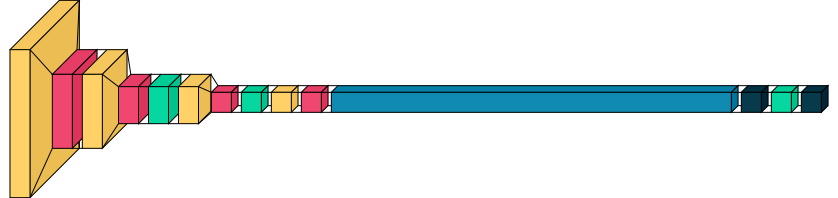

In [19]:
import visualkeras

visualkeras.layered_view(model = model, scale_xy=1)

0. <font color='#aaa'>&#11044;</font> Input &#8594; `(150, 150, 3)`
2. <font color='#EBBE36'>&#11044;</font> Capa Convolucional &#8594; `(148, 148, 32)`, `padding = 'valid'`
2. <font color='#E53F65'>&#11044;</font> Max Pooling 2x2 &#8594; `(74, 74, 32)`
2. <font color='#EBBE36'>&#11044;</font> Capa Convolucional &#8594; `(74, 74, 32)`, `padding = 'same'`
2. <font color='#E53F65'>&#11044;</font> Max Pooling 2x2 &#8594; `(37, 37, 32)`
2. <font color='#0EC286'>&#11044;</font> Dropout (0.25) &#8594; `(37, 37, 32)`
2. <font color='#EBBE36'>&#11044;</font> Capa Convolucional &#8594; `(37, 37, 64)`, `padding = 'same'`
2. <font color='#E53F65'>&#11044;</font> Max Pooling 2x2 &#8594; `(18, 18, 64)`
2. <font color='#0EC286'>&#11044;</font> Dropout (0.25) &#8594; `(18, 18, 64)`
2. <font color='#EBBE36'>&#11044;</font> Capa Convolucional &#8594; `(18, 18, 64)`, `padding = 'same'`
2. <font color='#E53F65'>&#11044;</font> Max Pooling 2x2 &#8594; `(9, 9, 64)`
2. <font color='#0075A2'>&#11044;</font> Flatten &#8594; `(5184)`
2. <font color='#003144'>&#11044;</font> Densa &#8594; `(64)`
2. <font color='#0EC286'>&#11044;</font> Dropout &#8594; `(64)`
2. <font color='#003144'>&#11044;</font> Densa &#8594; `(1)`

### Callbacks
Usaremos dos **`callbacks`** de Keras durante el entrenamiento:
- **`ModelCheckpoint`**: Permite guardar el modelo con cierta frecuencia dureante el entrenamiento.
- **`EarlyStopping`**: Permite detener la ejecución del entrenamiento si cierta métrica, definida por el usuario, no mejora depués de cierto criterio (en este caso el número de épocas).

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Early Stopping
early_stop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = 10
)

# ModelCheckpoint
model_filepath = f"{root_path}/modelo_neu_jrl.h5"
checkpoint = ModelCheckpoint(model_filepath, 
                monitor        = 'val_loss', 
                verbose        = 1, 
                save_best_only = True, 
                mode           = 'min'
)

# Lista de Callbacks
callbacks_list = [checkpoint, early_stop]

### Métricas de evaluación

In [21]:
from tensorflow.keras.metrics import BinaryAccuracy, \
      AUC, Recall, Precision

metrics = [BinaryAccuracy(name = 'accuracy'),
           AUC(name = 'roc_auc'),
           Precision(name ='precision'),
           Recall(name = 'recall')]

### Optimizador a utilizar

In [22]:
from tensorflow.keras.optimizers import Nadam

optimizer = Nadam(
      learning_rate = 0.001, 
      beta_1        = 0.9, 
      beta_2        = 0.999, 
      epsilon       = 1e-07,
      name          = 'Nadam'
    )

### Compilación del modelo

In [23]:
# Compilamos el modelo
model.compile(
    optimizer = optimizer,
    loss      = 'binary_crossentropy',
    metrics   = metrics
)

### Entrenamiento de la red

In [24]:
%%time
BATCH_SIZE = 64
EPOCHS = 50

# Entrenamiento
history = model.fit(
            train_generator, 
            validation_data = val_generator,
            epochs          = EPOCHS, 
            batch_size      = BATCH_SIZE,
            callbacks       = callbacks_list
          )

Epoch 1/50
147/147 [==============================] - 79s 511ms/step - loss: 0.5872 - accuracy: 0.7247 - roc_auc: 0.5726 - precision: 0.7280 - recall: 0.9887 - val_loss: 0.5739 - val_accuracy: 0.7466 - val_roc_auc: 0.7769 - val_precision: 0.7439 - val_recall: 0.9953

Epoch 00001: val_loss improved from inf to 0.57385, saving model to /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/modelo_neu_jrl.h5
Epoch 2/50
147/147 [==============================] - 74s 505ms/step - loss: 0.4403 - accuracy: 0.7946 - roc_auc: 0.8354 - precision: 0.8137 - recall: 0.9291 - val_loss: 0.3253 - val_accuracy: 0.8373 - val_roc_auc: 0.9156 - val_precision: 0.8529 - val_recall: 0.9390

Epoch 00002: val_loss improved from 0.57385 to 0.32534, saving model to /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/modelo_neu_jrl.h5
Epoch 3/50
147/147 [==============================] - 74s 504ms/step - loss: 0.3155 - accuracy: 0.8549 - roc_auc: 0.9234 - precision: 0.8723 - recall: 0.9389 - val_loss: 

#### Guarda el modelo y el el objeto `history`

In [25]:
model.save(f"{root_path}/modelo_cnn_jrl_TRAINED.h5")

In [30]:
import pickle
history = history.history
with open(f"{root_path}/history_cnn.pkl", 'wb') as file:
  pickle.dump(history, file)

In [ ]:
# Carga del modelo
# import pickle
# model = k.models.load_model(f"{root_path}/modelo_neu_jrl.h5")
# with open(f"{root_path}/history_cnn.pkl", 'rb') as file:
#   history = pickle.load( file )

## Evaluación del modelo

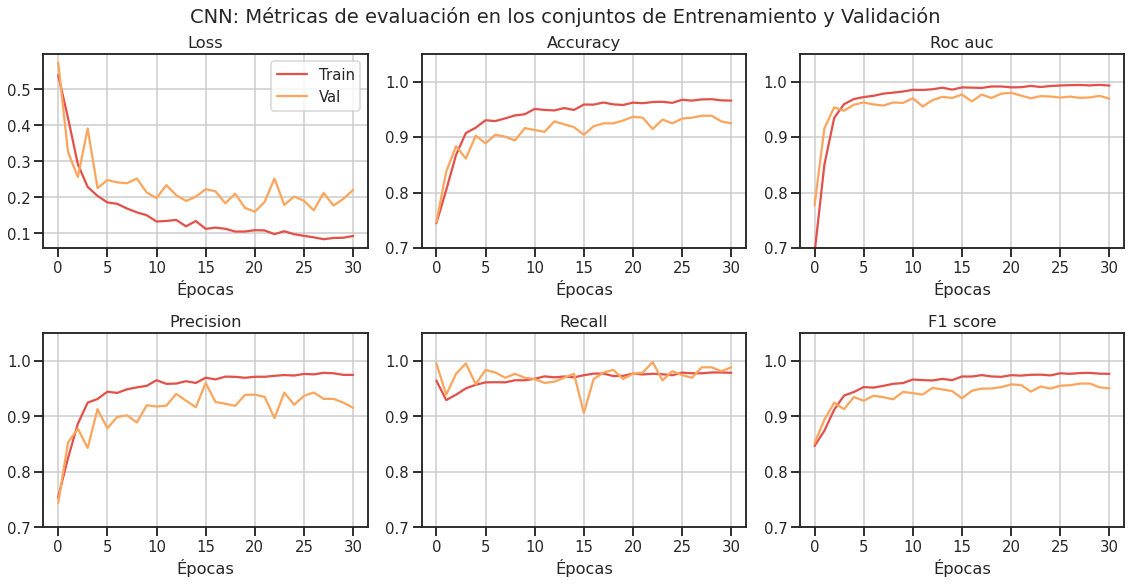

In [52]:
#@title Desempeño de la red durante el entrenamiento
#@markdown (desplegar para ver el código)

# Calculamos el F1 score a partir de los resultados de Precision y Recall
def get_f1_score(precision_arr, recall_arr):
  epsilon       = 1e-7
  precision_arr = np.array(precision_arr)
  recall_arr    = np.array(recall_arr)
  f1 = (2) * (precision_arr*recall_arr) / \
      (precision_arr + recall_arr + epsilon)
  return f1

def plot_history(train_hist, suptitle=''):
  # Agregar F1 score
  train_hist['F1_score']     = get_f1_score(train_hist['precision'], 
                                    train_hist['recall'])
  train_hist['val_F1_score'] = get_f1_score(train_hist['val_precision'], 
                                    train_hist['val_recall'])

  # Gráficas
  metrics = [key for key in train_hist.keys() 
              if not key.startswith('val')]

  fig, ax = plt.subplots(2, int(len(metrics)/2), 
                        figsize = (16, 8))
  for i, metric in enumerate(metrics):
    if i < 3: 
      j = 0
    else: 
      i, j = i - 3, 1
    ax[j, i].plot(train_hist[metric])
    ax[j, i].plot(train_hist[f"val_{metric}"])
    ax[j, i].set_title(metric.replace('_', ' ').capitalize())
    ax[j, i].set_xlabel('Épocas')
    ax[j, i].grid()
    if metric != 'loss':
      ax[j, i].set_ylim(0.7, 1.05)
    else:
      ax[j, i].legend(['Train', 'Val'])
  plt.tight_layout()
  plt.suptitle(suptitle, y = 1.02)
  plt.show()


# Ejecutamos la función
train_hist = history #.history.copy()
plot_history(train_hist, 
      suptitle='CNN: Métricas de evaluación en ' + 
      'los conjuntos de Entrenamiento y Validación')

### Evaluación con el conjunto de prueba

In [56]:
score_test = model.evaluate(test_generator, batch_size=128)

for i, j in zip(history.keys(), score_test):
  print(f'{i.upper()}: {j:.3f}')

19/19 [==============================] - 5s 226ms/step - loss: 0.4822 - accuracy: 0.8904 - roc_auc: 0.9339 - precision: 0.8740 - recall: 0.9930
LOSS: 0.482
ACCURACY: 0.890
ROC_AUC: 0.934
PRECISION: 0.874
RECALL: 0.993


Otenemos las etiquetas reales y las etiquetas predichas del conjunto de prueba.

In [57]:
# Etiquetas reales 
y_test = test_generator.classes
# Predicciones
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred >= 0.5).astype('int32')

#### Matriz de confusión

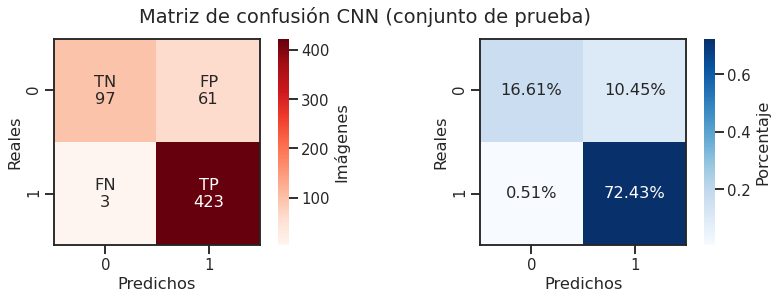

In [58]:
#@markdown (desplegar para ver el código)

from sklearn.metrics import confusion_matrix

def plot_cfn_matrix(y_test, y_pred_classes, suptitle=''):
  cf_matrix = confusion_matrix(y_test, y_pred_classes)

  labels_a = np.array(
      [f'{i}\n{j}' 
      for i, j in
        zip(['TN', 'FP', 'FN', 'TP'],
              cf_matrix.flatten()
          )
      ]).reshape(2,2)

  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  # Valores crudos
  sns.heatmap(cf_matrix, 
              cmap = 'Reds', ax = ax[0], 
              fmt = '', annot = labels_a,
              cbar_kws={'label': 'Imágenes'})
  # Porcentajes
  sns.heatmap(cf_matrix/np.sum(cf_matrix), 
              cmap = 'Blues', ax = ax[1], 
              fmt = '.2%', annot = True,
              cbar_kws={'label': 'Porcentaje'})
  for i in range(2):
    ax[i].set(aspect = "equal", 
              xlabel = 'Predichos', ylabel = 'Reales')
    for _, spine in ax[i].spines.items():
      spine.set_visible(True)
  plt.suptitle(suptitle, y = 1.05)
  plt.tight_layout()

# Genera la gráfica
plot_cfn_matrix(y_test, y_pred_classes, 
    suptitle='Matriz de confusión CNN (conjunto de prueba)')

#### Curva ROC y Curva de Precisión Sensibilidad

Para esta evaluación usamos las métricas:
- Área bajo la curva ROC.
- Promedio de Precisión-Sensibilidad (*avgPR*):
  > $\text{AP} = \sum_n (R_n - R_{n-1}) P_n$

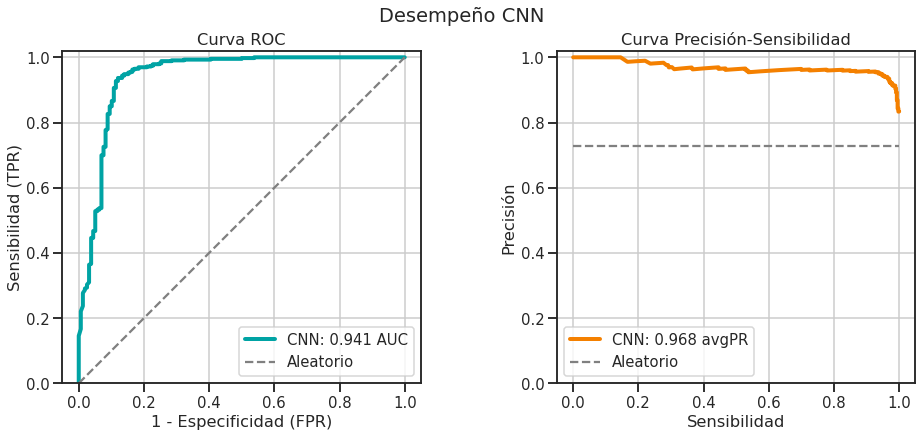

In [63]:
#@markdown (desplegar para ver el código)

from sklearn.metrics import roc_auc_score, roc_curve, \
          f1_score, precision_recall_curve, average_precision_score

def plot_roc_and_pr_curves(y_test, y_pred, 
                           suptitle='', name = ''):
  auc_ = roc_auc_score(y_test, y_pred)
  f1_score_ = roc_auc_score(y_test, y_pred)
  vg_pr_score = average_precision_score(y_test, y_pred)

  fpr, tpr, _ = roc_curve(y_test, y_pred)
  prec_, recall_, _ = precision_recall_curve(y_test, y_pred)
  pr_baseline = y_test.sum() / len(y_test)

  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  # Curva ROC
  ax[0].plot(fpr, tpr, c = '#00A3A4', 
            linewidth = 4, label = f'{name}: {auc_:.3f} AUC')
  ax[0].plot([0, 1], [0, 1], c = 'gray',
            linestyle = '--', label = 'Aleatorio')
  ax[0].legend()
  ax[0].set(xlabel = '1 - Especificidad (FPR)',
            ylabel = 'Sensibilidad (TPR)')

  # Curva de Precision-Sensibilidad
  ax[1].plot(recall_, prec_, c = '#F48000', 
            linewidth = 4, label = f'{name}: {vg_pr_score:.3f} avgPR')
  ax[1].plot([0, 1], [pr_baseline, pr_baseline], c = 'gray',
            linestyle = '--', label = 'Aleatorio')
  ax[1].legend()
  ax[1].set(xlabel = 'Sensibilidad',
            ylabel = 'Precisión')
  for i, title in enumerate(['Curva ROC', 
                            'Curva Precisión-Sensibilidad']):
    ax[i].set(aspect='equal', ylim=(0,1.02), title=title)
    ax[i].grid(True)
  plt.tight_layout()
  plt.suptitle(suptitle, y = 1.02)
  plt.show()

# Genera la gráfica
plot_roc_and_pr_curves(y_test, y_pred, 
          suptitle='Desempeño CNN', name = 'CNN')

### Interpretación de Resultados

**Vemos que la CNN obtiene buenos valores de desempeño en todas las métricas.**
- En particular **nos interesa que la sensibilidad del modelo sea alta (0.98)** y por consecuencia que el número de Falsos Negativos sea bajo (9 FN).
- Se observa que **el modelo sólo identificó 9 Falsos Negativos**, lo cual es un buen resultado pues nos interesa que casos verdaderos de neumonía **NO** sean identificados como casos NORMALES.
- El **modelo tiene una mayor sensibilidad (0.98) que precisión (0.89)**. Es un buen resultado, pero hay que considerar que esto también es consecuencia de que en el conjunto de datos haya considerablemente más ejemplos positivos que negativos.

***

# Transferencia de conocimiento


## Uso de la red VGG16

Para esta fase vamos a implementar el método de transferencia de conocimiento (*Transfer learning*) usando la red **VGG16** (Simonyan and Zisserman, 2015).

In [36]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights     = 'imagenet',
              include_top = False,
              # Definimos el tamaño de la capa de entrada
              # igual a las dimensiones de las imágenes
              input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

#### Visualizamos la arquitectura de la VGG16

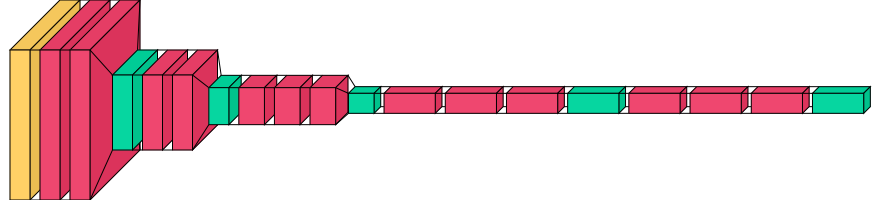

In [37]:
visualkeras.layered_view(vgg16, scale_xy=1)

In [38]:
from tensorflow.keras.layers import Input
# Creamos nuestro nuevo modelo

# Primero congelamos los pesos de las primeras capas de VGG16
vgg16.trainable = False

model_vgg16 = Sequential()
# Añadimos a VGG16 como si fuese una capa
model_vgg16.add(Input(shape = (IMG_HEIGHT, IMG_WIDTH, 3)))
model_vgg16.add(vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(128, 
                  activation='relu'))
model_vgg16.add(Dropout(0.4))
model_vgg16.add(Dense(1, 
                      activation='sigmoid', 
                      bias_initializer = output_bias))
model_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


Listo, el modelo tiene 524,417 de parámetros entrenables.

### Compilamos el modelo basado en VGG16

In [39]:
# Usamos las mismas métricas de evaluación
metrics = [BinaryAccuracy(name = 'accuracy'),
           AUC(name = 'roc_auc'),
           Precision(name ='precision'),
           Recall(name = 'recall')
          ]

# Compilamos el modelo
model_vgg16.compile(
    optimizer = optimizer,
    loss      = 'binary_crossentropy',
    metrics   = metrics
)

### Entrenamiento del moelo basado en VGG16
#### Callbacks

In [40]:
BATCH_SIZE = 64
EPOCHS = 50

# ModelCheckpoint
model_filepath = f"{root_path}/modelo_vgg16_jrl.h5"
checkpoint_vgg16 = ModelCheckpoint(model_filepath, 
                monitor        = 'val_loss', 
                verbose        = 1, 
                save_best_only = True, 
                mode           = 'min'
)

# Lista de Callbacks
callbacks_list_vgg16 = [checkpoint_vgg16, early_stop]

### Entrenamiento de la red

In [41]:
%%time
# Entrenamiento
history_vgg16 = model_vgg16.fit(
          train_generator, 
          validation_data = val_generator,
          epochs          = EPOCHS, 
          batch_size      = BATCH_SIZE,
          callbacks       = callbacks_list_vgg16
)

Epoch 1/50
147/147 [==============================] - 86s 555ms/step - loss: 1.1479 - accuracy: 0.8489 - roc_auc: 0.8704 - precision: 0.8874 - recall: 0.9027 - val_loss: 0.2040 - val_accuracy: 0.9195 - val_roc_auc: 0.9656 - val_precision: 0.9397 - val_recall: 0.9507

Epoch 00001: val_loss improved from inf to 0.20395, saving model to /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/modelo_vgg16_jrl.h5
Epoch 2/50
147/147 [==============================] - 78s 532ms/step - loss: 0.1513 - accuracy: 0.9360 - roc_auc: 0.9830 - precision: 0.9473 - recall: 0.9647 - val_loss: 0.2019 - val_accuracy: 0.9195 - val_roc_auc: 0.9677 - val_precision: 0.9566 - val_recall: 0.9319

Epoch 00002: val_loss improved from 0.20395 to 0.20186, saving model to /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/modelo_vgg16_jrl.h5
Epoch 3/50
147/147 [==============================] - 79s 534ms/step - loss: 0.1478 - accuracy: 0.9409 - roc_auc: 0.9826 - precision: 0.9522 - recall: 0.9677 - val_lo

In [42]:
model_vgg16.save(f"{root_path}/modelo_vgg16_jrl_TRAINED.h5")

In [43]:
history_vgg16 = history_vgg16.history
with open(f"{root_path}/history_cnn_vgg16.pkl", 'wb') as file:
  pickle.dump(history_vgg16, file)

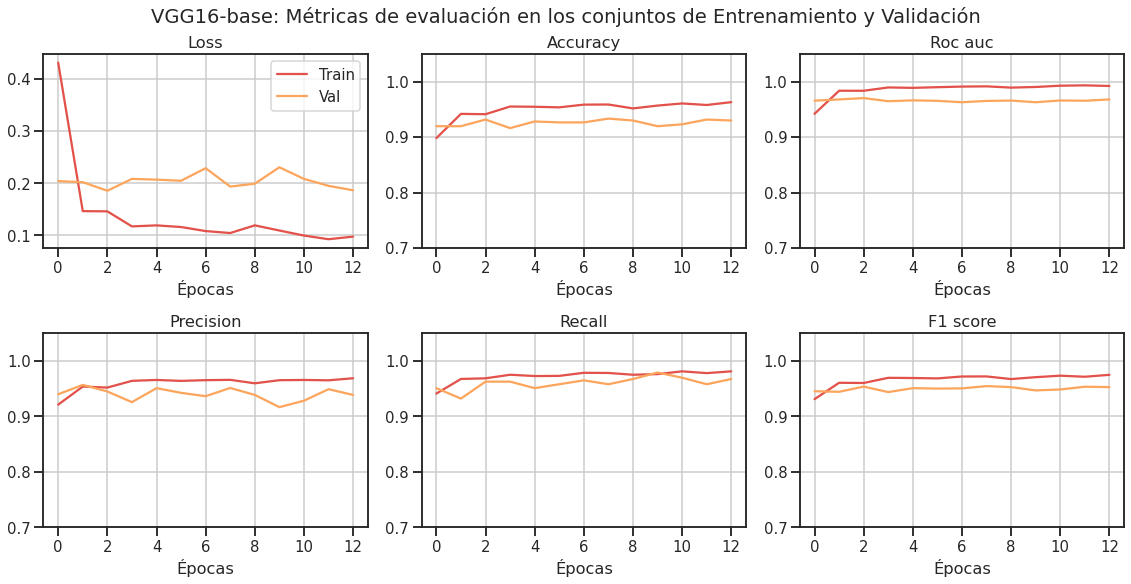

In [53]:
# Ejecutamos la función
train_hist_v16 = history_vgg16.copy()
plot_history(train_hist_v16, 
      suptitle='VGG16-base: Métricas de evaluación en ' + 
      'los conjuntos de Entrenamiento y Validación')

In [47]:
score_test_vgg16 = model_vgg16.evaluate(test_generator, batch_size=64)

for i, j in zip(train_hist_v16.keys(), score_test_vgg16):
  print(f'{i.upper()}: {j:.2f}')

19/19 [==============================] - 5s 251ms/step - loss: 0.2621 - accuracy: 0.9092 - roc_auc: 0.9625 - precision: 0.8943 - recall: 0.9930
LOSS: 0.26
ACCURACY: 0.91
ROC_AUC: 0.96
PRECISION: 0.89
RECALL: 0.99


In [48]:
# Etiquetas reales 
# y_test = test_generator.classes
# Predicciones
y_pred_v16 = model_vgg16.predict(test_generator)
y_pred_classes_v16 = (y_pred_v16 >= 0.5).astype('int32')

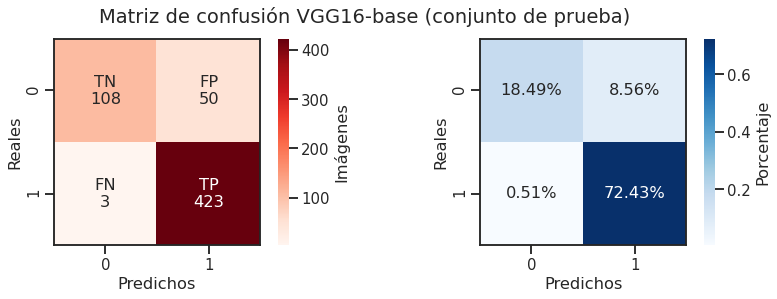

In [49]:
#@markdown (desplegar para ver el código)

# Genera la gráfica
plot_cfn_matrix(y_test, y_pred_classes_v16, 
    suptitle='Matriz de confusión VGG16-base (conjunto de prueba)')

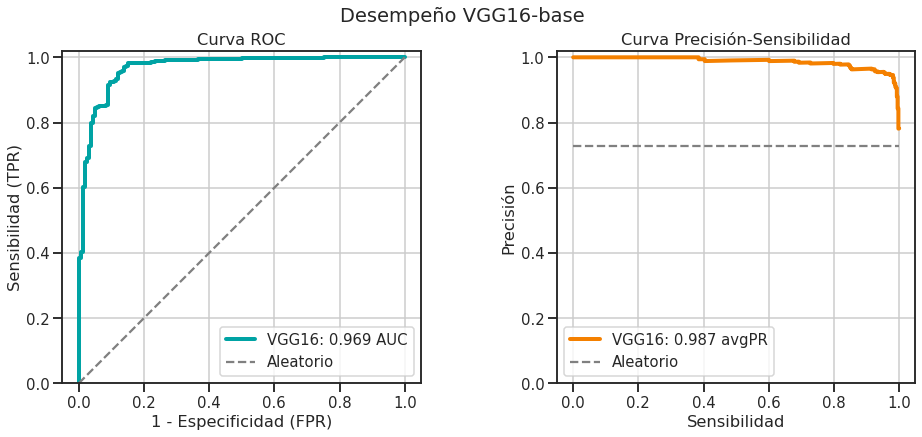

In [65]:
# Genera la gráfica
plot_roc_and_pr_curves(y_test, y_pred_v16, 
          suptitle = 'Desempeño VGG16-base',
          name = 'VGG16')

## Interpretación de Resultados

La red VGG16 mostró buenos resultados, teniendo un desempeño similar al de la primer red (CNN) en términos de Sensibilidad. Sin embargo, mostró una mejora en la precisión y por consiguiente en el Área bajo la curva ROC, así como un mayor valor de *avgPR*.

# Referencias

1. Mariano Rivera (2018). **[Reeuso de Redes Preentrenadas](http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/preentrenadas/preentrenadas.html)**. *Consultado el 18 de marzo del 2021.*
2. Eunjoo Byeon (2020). **[Exploratory Data Analysis Ideas for Image Classification](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2)**. En towardsdatascience.com. *Consultado el 18 de marzo del 2021.*
3. Paul Mooney (2018). **[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)**. En kaggle.com. *Consultado el 18 de marzo del 2021.*
4. Chollet, Francois (2017). **Deep Learning with Python.** New York, NY: Manning Publications.